<a href="https://colab.research.google.com/github/AleksandrRevuka/Algo_data_science/blob/main/6_Practical_skills_1_2_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EDA:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import seaborn as sns

In [44]:
buildings = pd.read_csv("http://video.ittensive.com/machine-learning/ashrae/building_metadata.csv.gz")
weather = pd.read_csv("http://video.ittensive.com/machine-learning/ashrae/weather_train.csv.gz")
energy = pd.read_csv("http://video.ittensive.com/machine-learning/ashrae/train.0.csv.gz")

In [36]:
def reduce_mem_usage(df):
  start_mem = df.memory_usage().sum() / 1024 ** 2
  for col in df.columns:
    col_type = df[col].dtypes
    if str(col_type)[:5] == "float":
      c_min = df[col].min()
      c_max = df[col].max()
      if c_min > np.finfo("f2").min and c_max < np.finfo("f2").max:
        df[col] = df[col].astype(np.float16)
      elif c_min > np.finfo("f4").min and c_max < np.finfo("f4").max:
        df[col] = df[col].astype(np.float32)
      else:
        df[col] = df[col].astype(np.float64)
    elif str(col_type)[:3] == "int":
        c_min = df[col].min()
        c_max = df[col].max()
        if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
            df[col] = df[col].astype(np.int8)
        elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
            df[col] = df[col].astype(np.int16)
        elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
            df[col] = df[col].astype(np.int32)
        elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
            df[col] = df[col].astype(np.int64)
    elif col == "timestamp":
      df[col] = pd.to_datetime(df[col])
    elif str(col_type)[:8] != "dataetime":
      df[col] = df[col].astype("category")
  end_mem = df.memory_usage().sum() / 1024 ** 2
  print(f"Споживання памяті меньше на {round(start_mem - end_mem, 2)}Mb (мінус {round(100 * (start_mem - end_mem) / start_mem, 1)}%)")
  return df

In [45]:
buildings = reduce_mem_usage(buildings)
weather = reduce_mem_usage(weather)
energy = reduce_mem_usage(energy)

Споживання памяті меньше на 0.05Mb (мінус 73.9%)
Споживання памяті меньше на 6.53Mb (мінус 68.1%)
Споживання памяті меньше на 195.54Mb (мінус 53.1%)


In [46]:
def round_fillna(df, columns):
  for col in columns:
    type_ = "int16"
    if col in ["wind_speed", "cloud_coverage", "precip_depth_1_hr"]:
      type_ = "int16"
    if col == "precip_depth_1_hr":
      df[col] = df[col].apply(lambda x: 0 if x < 0 else x)
    df[col] = np.round(df[col].fillna(value=0)).astype(type_)
  return df

In [47]:
energy = pd.merge(left=energy, right=buildings, how="left", left_on="building_id", right_on="building_id")

energy = energy.set_index(["timestamp", "site_id"])
weather = weather.set_index(["timestamp", "site_id"])

energy = pd.merge(left=energy, right=weather, how="left", left_index=True, right_index=True)
energy.reset_index(inplace=True)
energy = energy.drop(columns=["meter"], axis=1)
energy = energy[energy['meter_reading'] > 0]

In [48]:
energy

,timestamp,site_id,building_id,meter_reading,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
45,2016-01-01 00:00:00,0,46,53.239700,Retail,9045,2016.0,NaN,25.000000,6.0,20.000000,NaN,1019.5,0.0,0.000000
72,2016-01-01 00:00:00,0,74,43.001301,Parking,387638,1997.0,NaN,25.000000,6.0,20.000000,NaN,1019.5,0.0,0.000000
91,2016-01-01 00:00:00,0,93,52.420601,Office,33370,1982.0,NaN,25.000000,6.0,20.000000,NaN,1019.5,0.0,0.000000
103,2016-01-01 00:00:00,1,105,23.303600,Education,50623,NaN,5.0,3.800781,NaN,2.400391,NaN,1021.0,240.0,3.099609
104,2016-01-01 00:00:00,1,106,0.374600,Education,5374,NaN,4.0,3.800781,NaN,2.400391,NaN,1021.0,240.0,3.099609
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12060904,2016-12-31 23:00:00,15,1443,64.949997,Education,40311,1913.0,NaN,1.700195,NaN,-5.601562,-1.0,1008.5,180.0,8.796875
12060905,2016-12-31 23:00:00,15,1444,8.750000,Entertainment/public assembly,19619,1914.0,NaN,1.700195,NaN,-5.601562,-1.0,1008.5,180.0,8.796875
12060906,2016-12-31 23:00:00,15,1445,4.825000,Education,4298,NaN,NaN,1.700195,NaN,-5.601562,-1.0,1008.5,180.0,8.796875
12060908,2016-12-31 23:00:00,15,1447,159.574997,Lodging/residential,29775,2001.0,NaN,1.700195,NaN,-5.601562,-1.0,1008.5,180.0,8.796875


In [ ]:
energy = round_fillna(energy, ["wind_direction", "wind_speed", "cloud_coverage", "precip_depth_1_hr", "year_built", "floor_count"])


del buildings
del weather
energy

<Figure size 600x600 with 0 Axes>

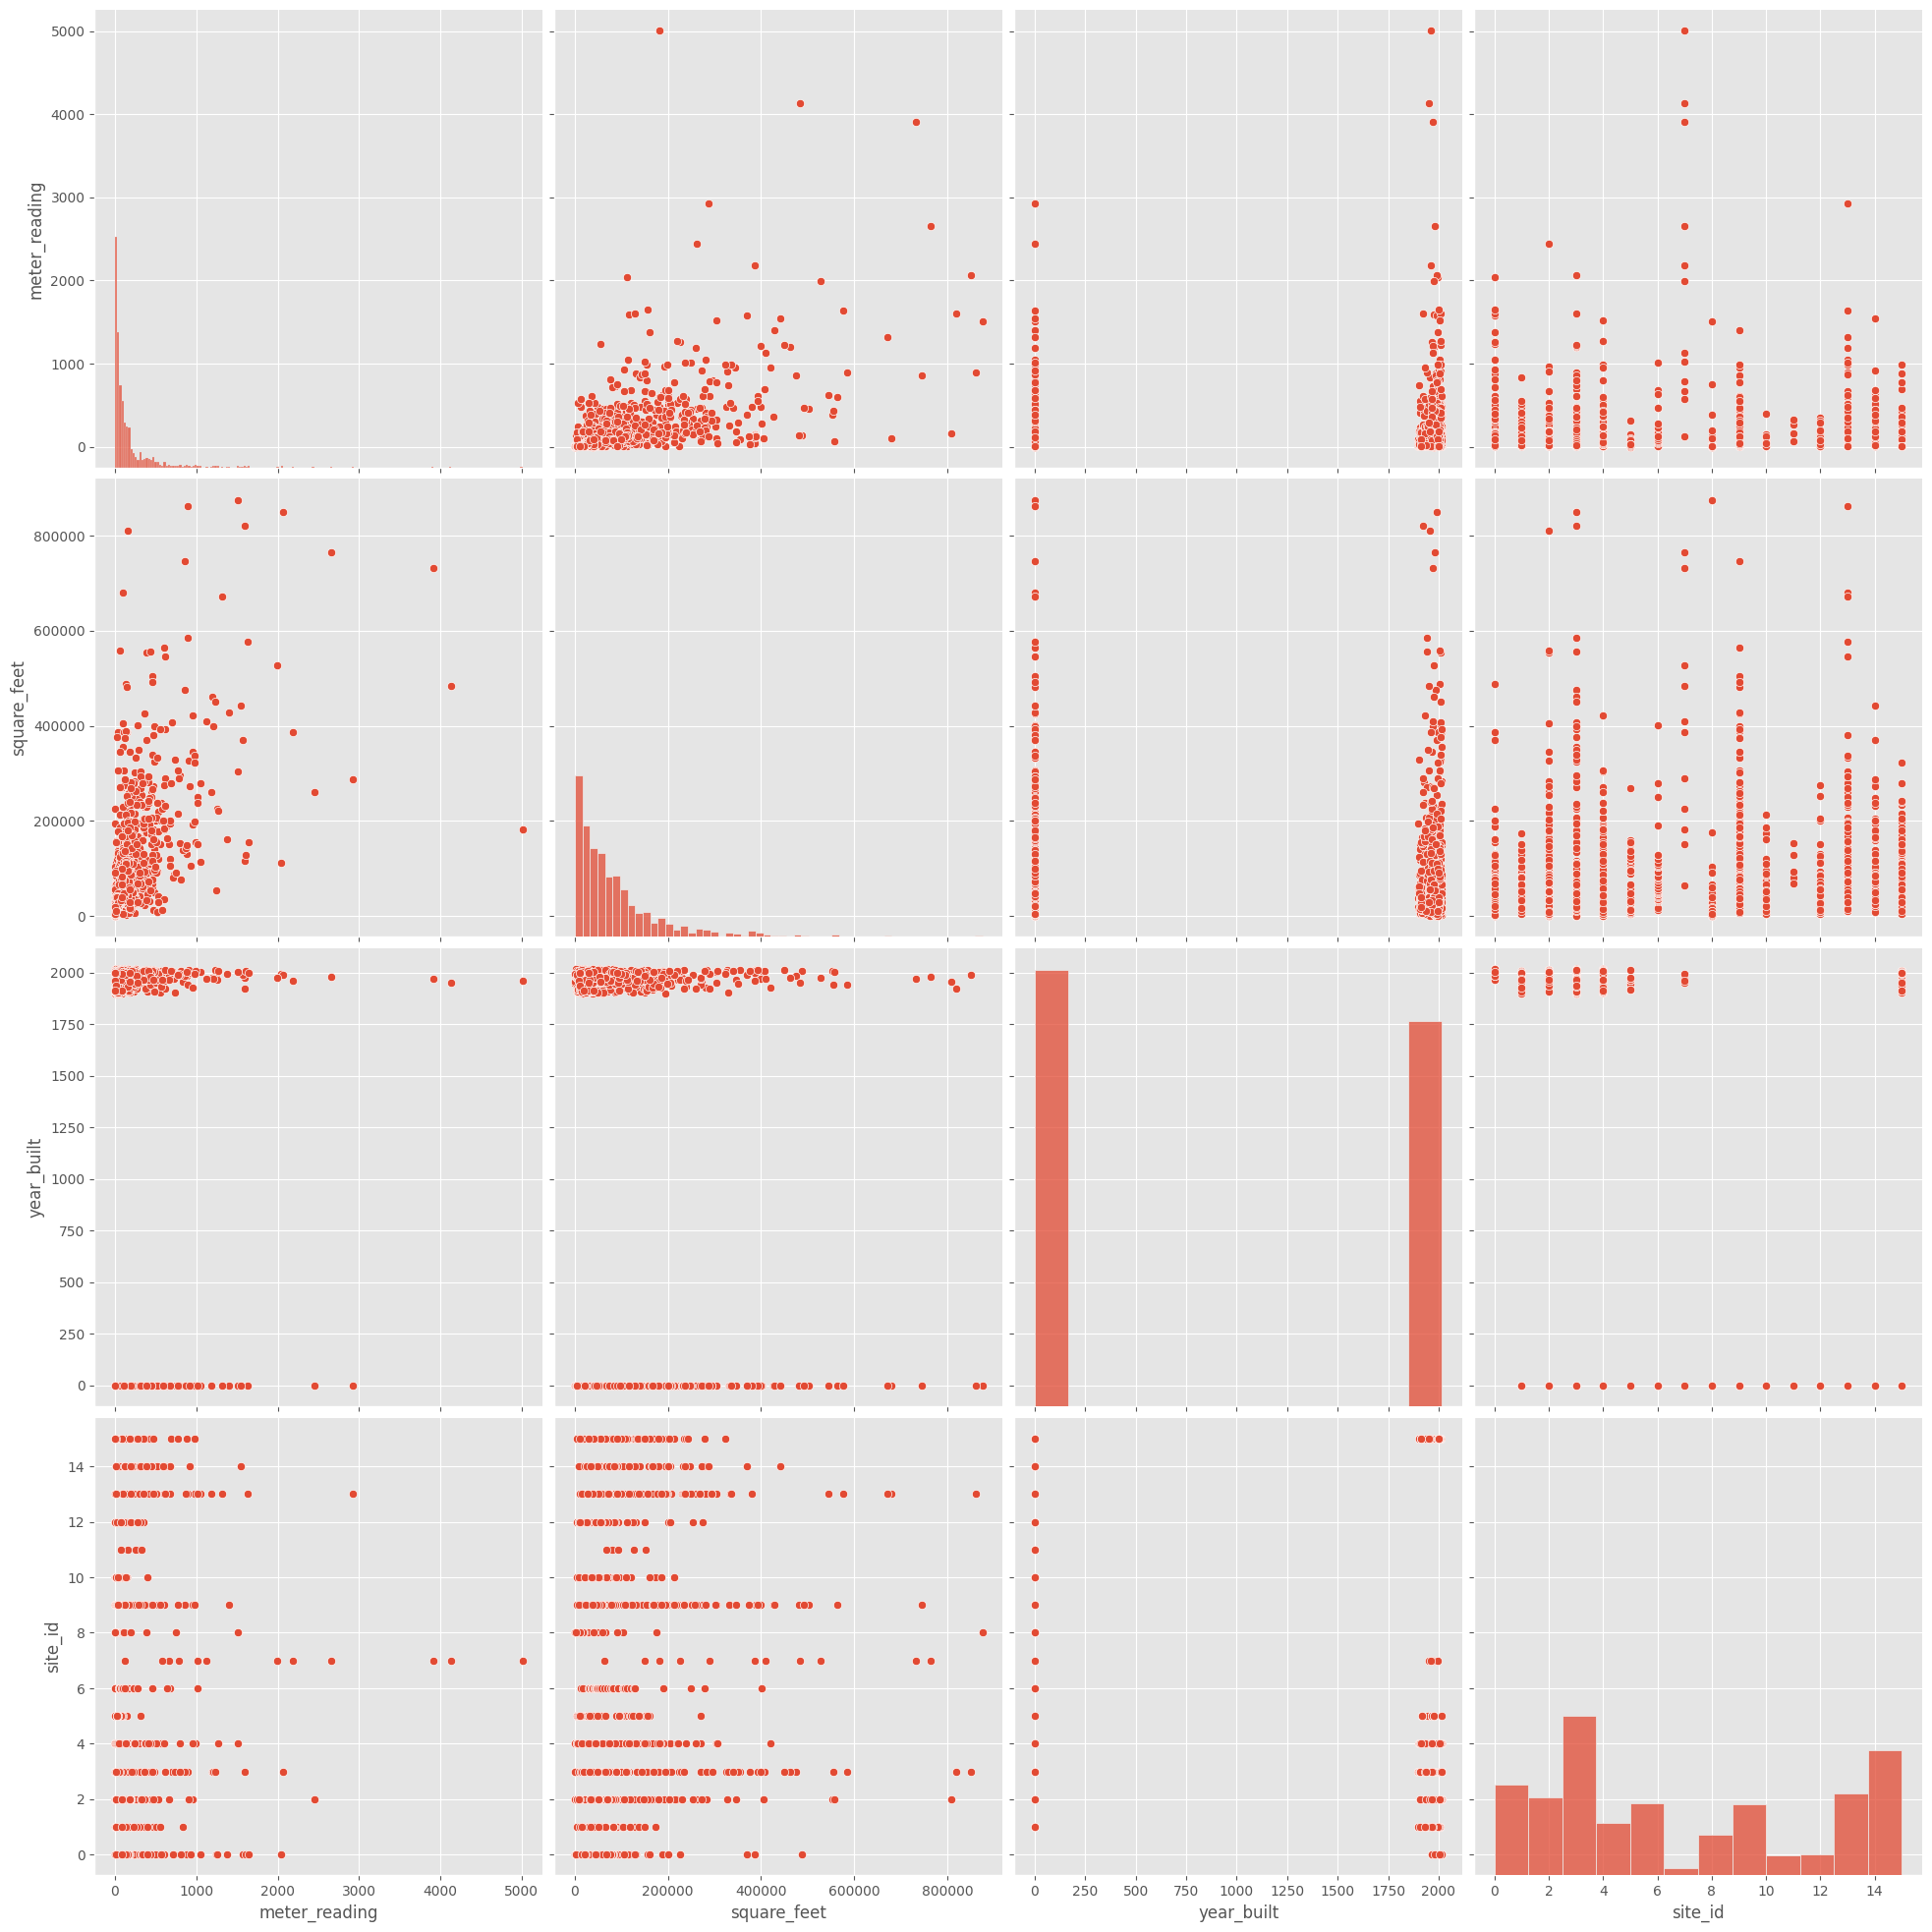

In [69]:
data_corr_meta = pd.DataFrame(
    energy.groupby("building_id")[["meter_reading", "square_feet", "year_built", "site_id"]].median()
)

data_corr_meta.dropna(inplace=True)
plt.style.use('ggplot')

plt.figure(figsize=(6, 6))
sns.pairplot(data_corr_meta, height=5)
plt.grid(linestyle='--')
plt.show()

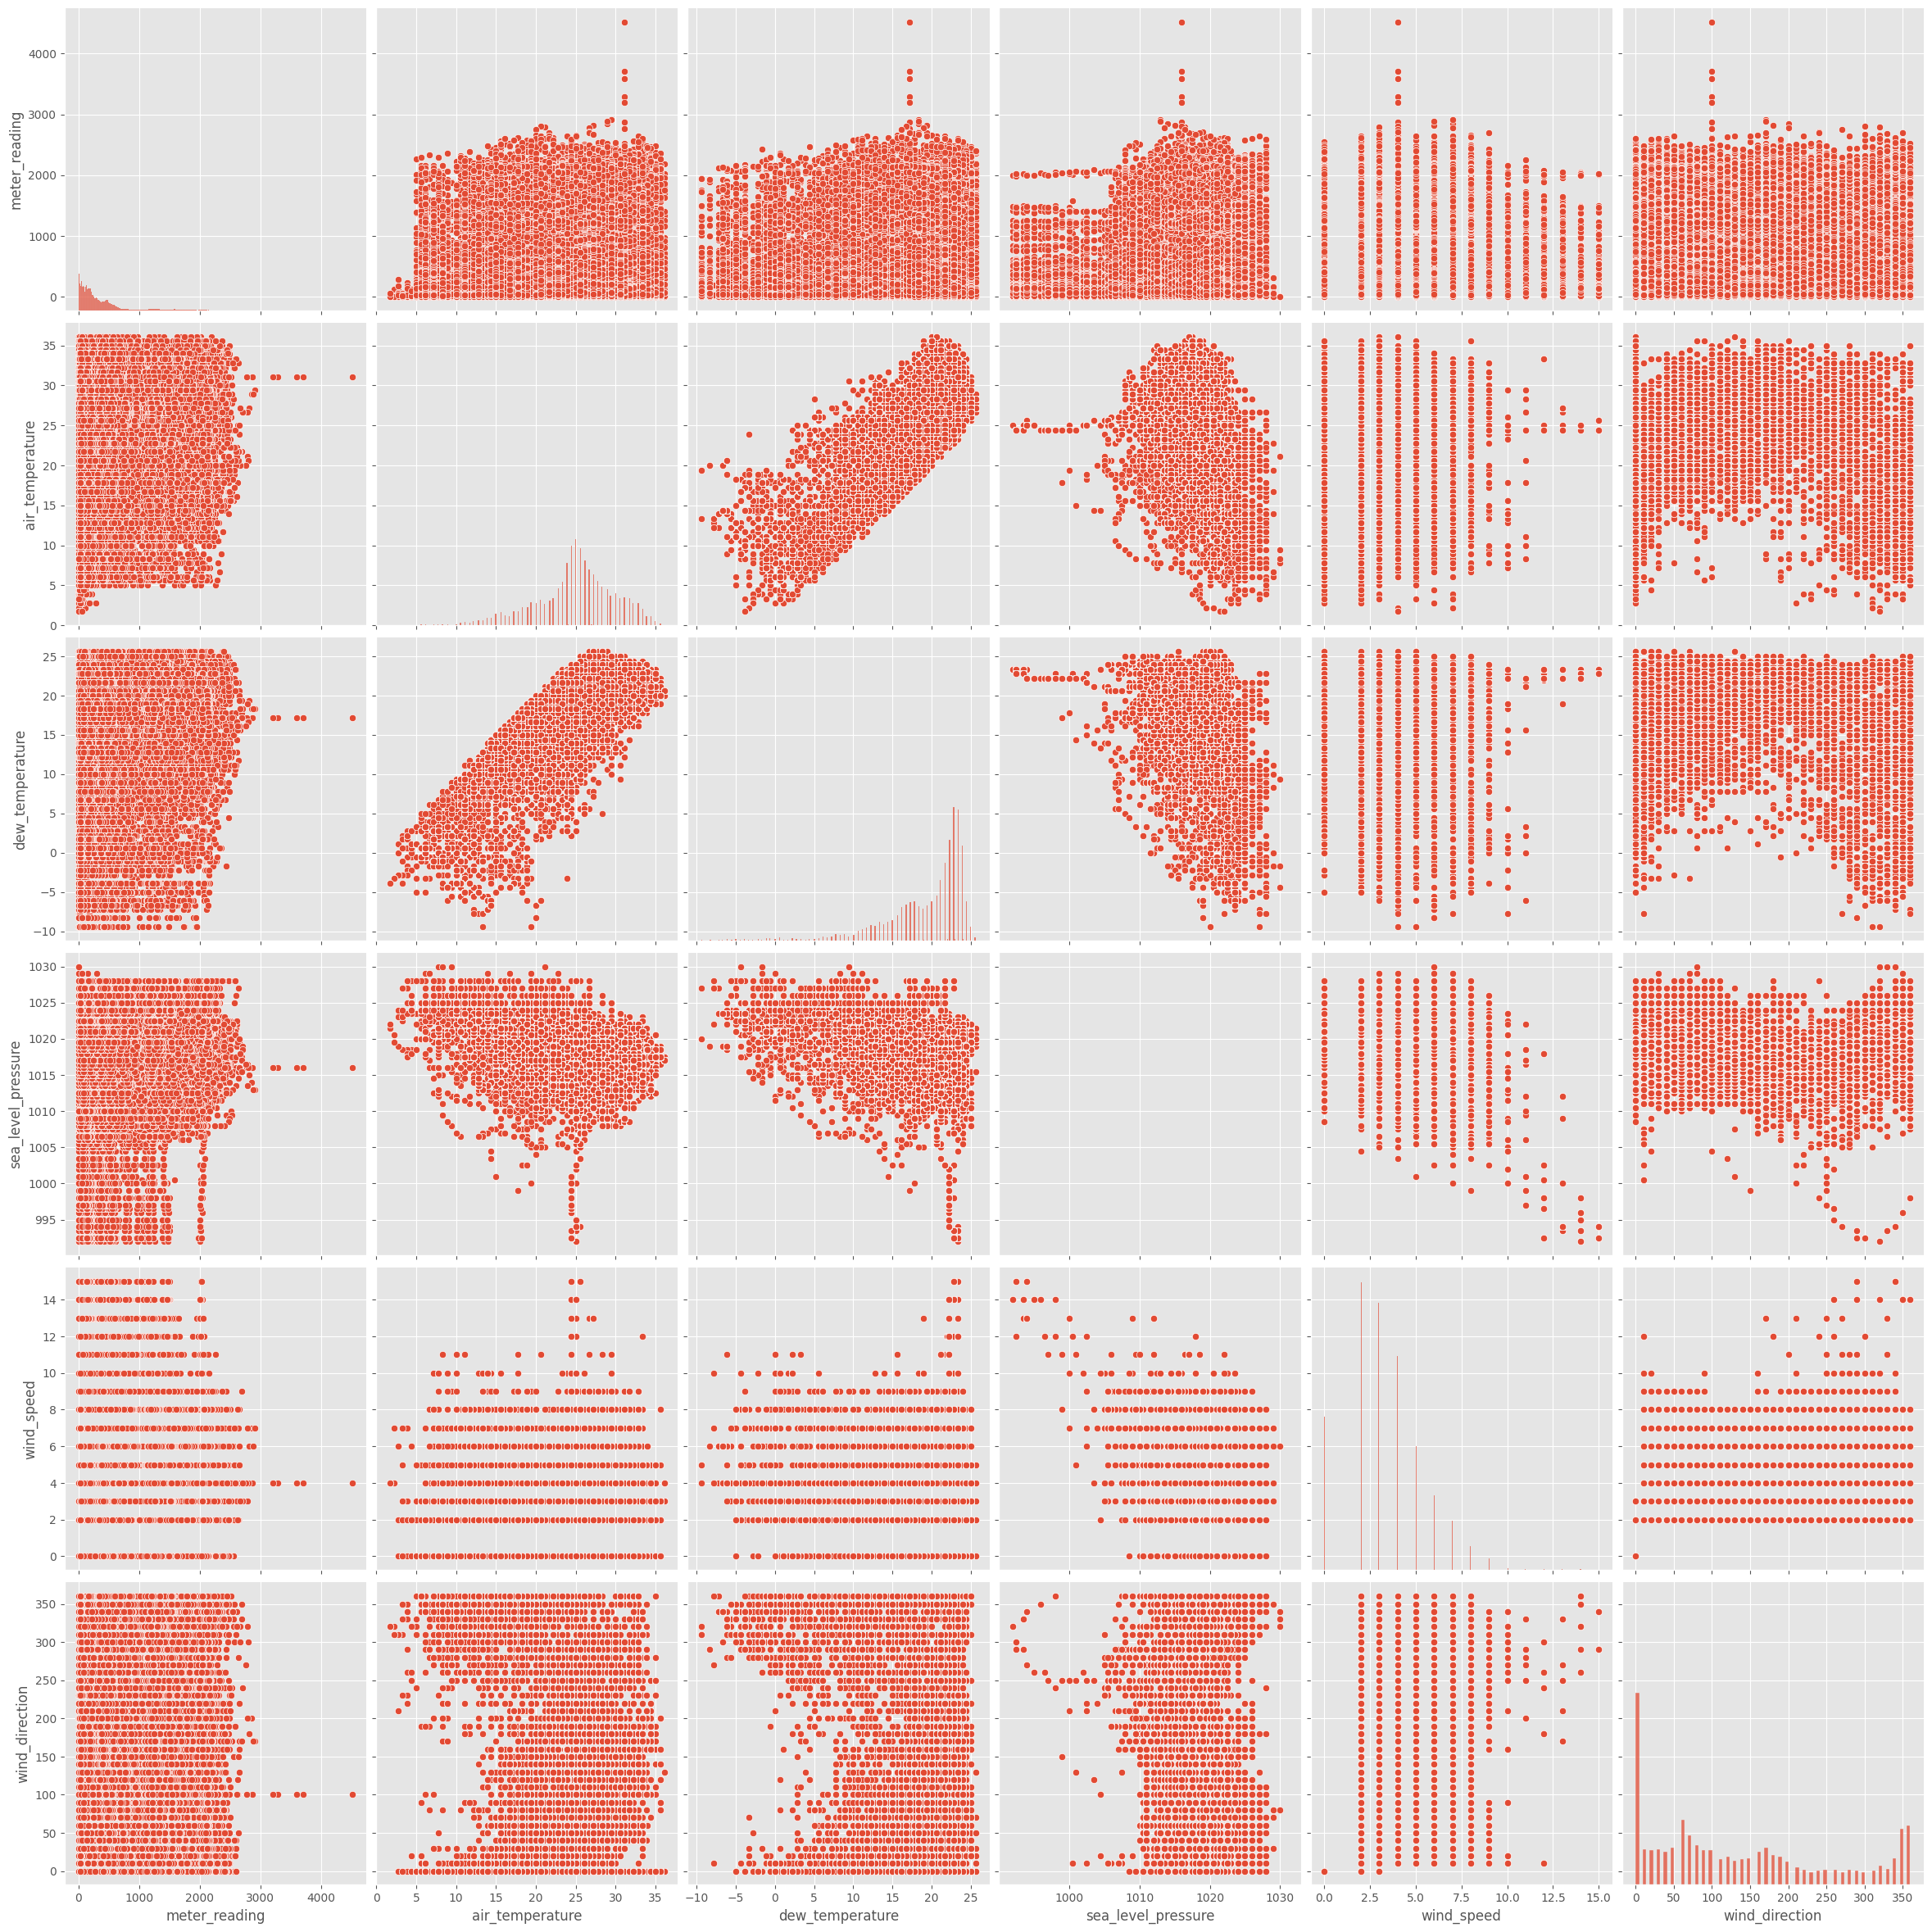

In [55]:
data_corr_weather = pd.DataFrame(energy[energy["site_id"] == 0],
                                 columns=["meter_reading", "air_temperature", "dew_temperature", "sea_level_pressure", "wind_speed", "wind_direction"])
data_corr_weather.dropna(inplace=True)
sns.pairplot(data_corr_weather, height=4)
plt.show()
del data_corr_weather

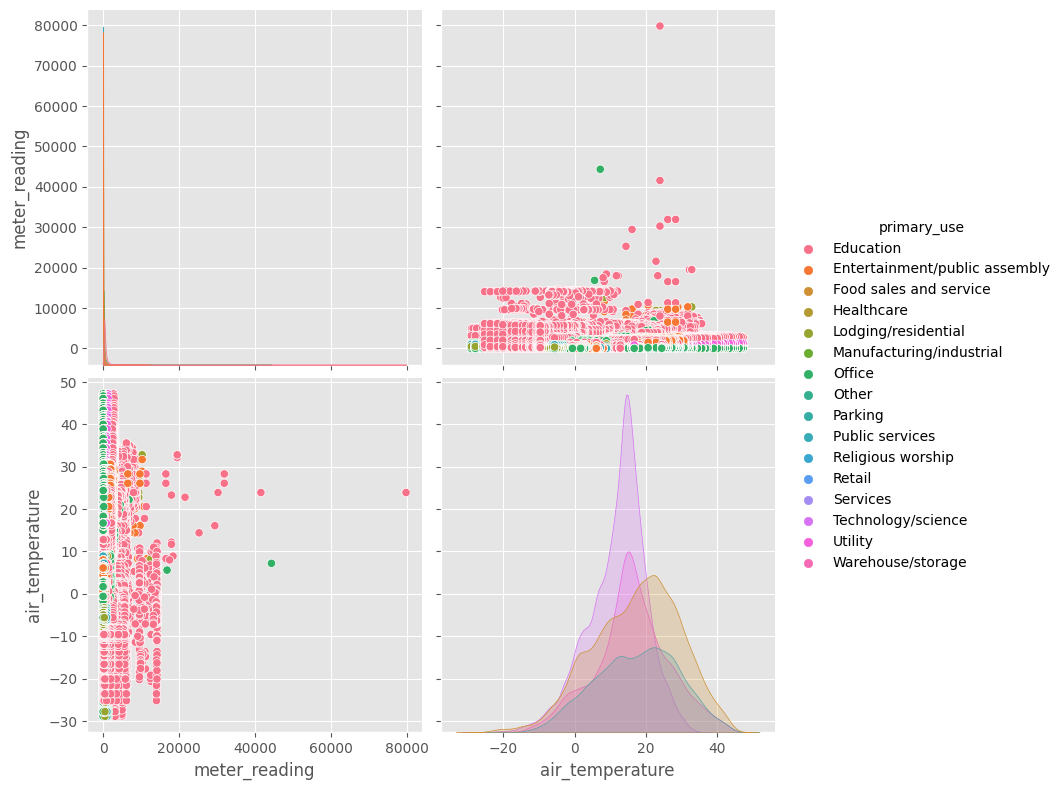

In [57]:
data_corr_temp_primary = pd.DataFrame(energy,
                                      columns=["meter_reading", "air_temperature", "primary_use"])
data_corr_temp_primary.dropna(inplace=True)
sns.pairplot(data_corr_temp_primary, hue="primary_use", height=4)
plt.show()
del data_corr_temp_primary

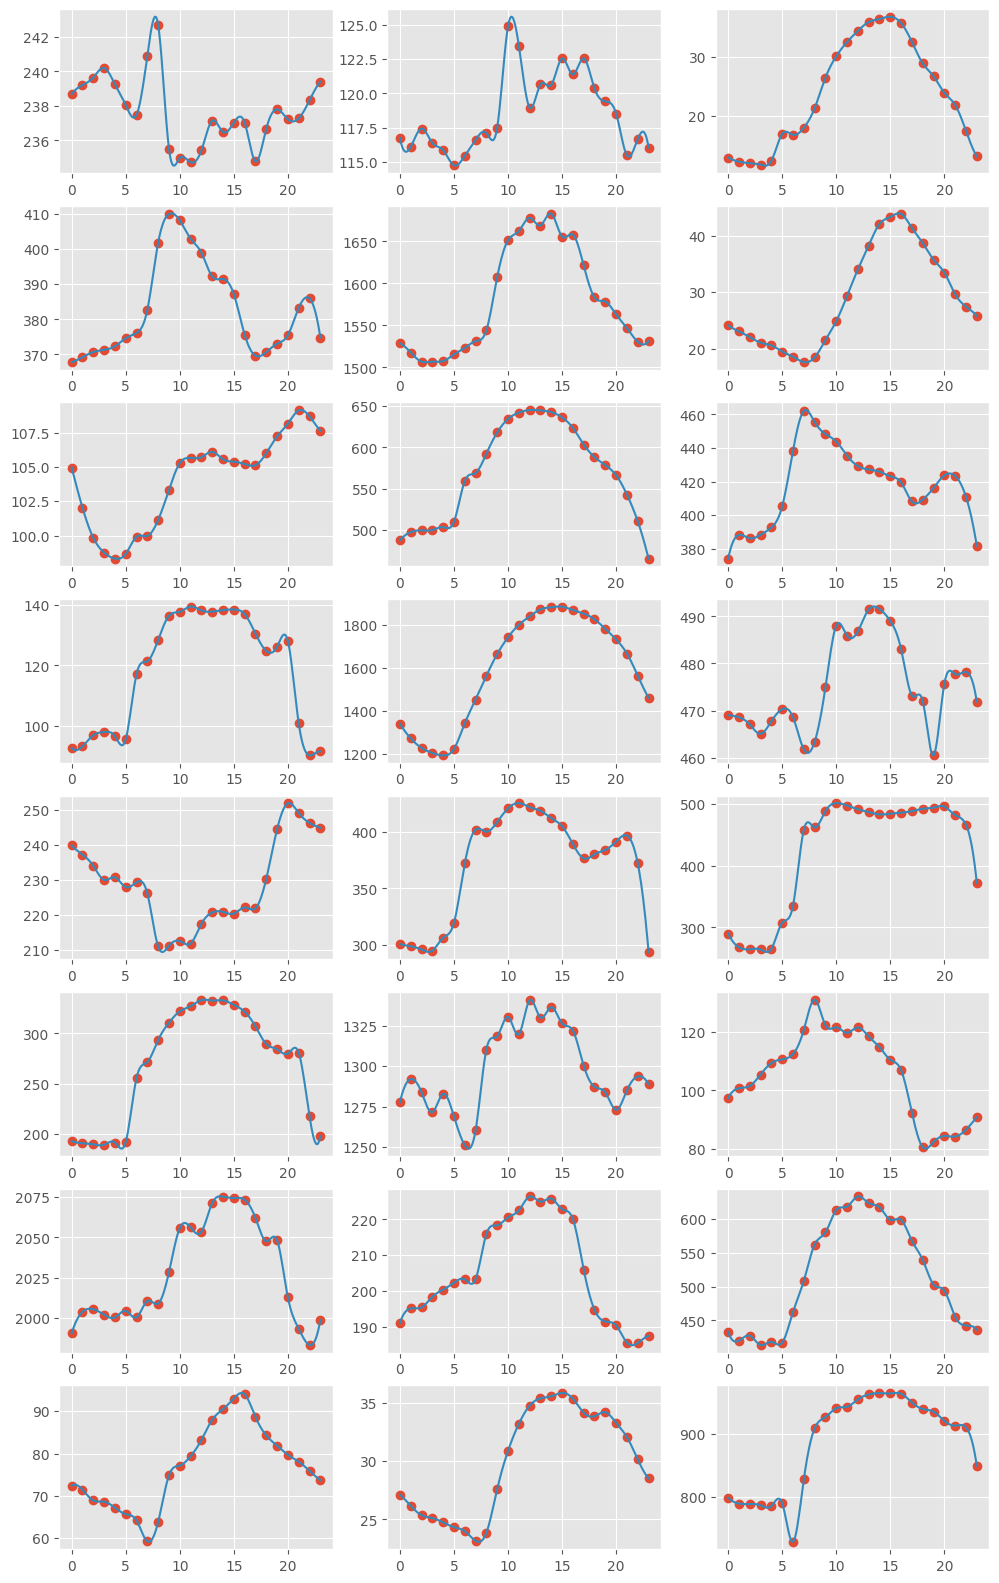

In [68]:
energy["hour"] = energy["timestamp"].dt.hour.astype("int8")
fig = plt.figure(figsize=(12,20))
for i in range(0, 24):
  fig.add_subplot(8, 3, i + 1)
  train_df_i = energy[(energy["building_id"] == i) & (energy["meter_reading"] > 0)]
  train_df_i_hourly = train_df_i.groupby("hour")["meter_reading"].mean().reset_index()
  x = np.arange(0, 24)
  y = interp1d(x, train_df_i_hourly["meter_reading"], kind="cubic")
  xn = np.arange(0, 23.1, 0.1)
  yn = y(xn)
  plt.plot(np.arange(0, 24),
           train_df_i_hourly["meter_reading"], "o", xn, yn, "-")
plt.show()

In [66]:
from pandas.tseries.holiday import USFederalHolidayCalendar  as calendar

dates_range = pd.date_range(start="2015-12-31", end="2017-01-01")
us_holidays = calendar().holidays(start=dates_range.min(), end=dates_range.max())

energy["dayofweek"] = energy["timestamp"].dt.dayofweek.astype("int8")
energy["day"] = energy["timestamp"].dt.day.astype("int8")
energy["dayofyear"] = energy["timestamp"].dt.dayofyear.astype("int16")
energy["month"] = energy["timestamp"].dt.month.astype("int8")
energy["week"] = energy["timestamp"].dt.isocalendar().week.astype("int8")

energy["date"] = pd.to_datetime(energy["timestamp"].dt.date)
energy["is_holiday"] = (energy["date"].isin(us_holidays)).astype("int8")

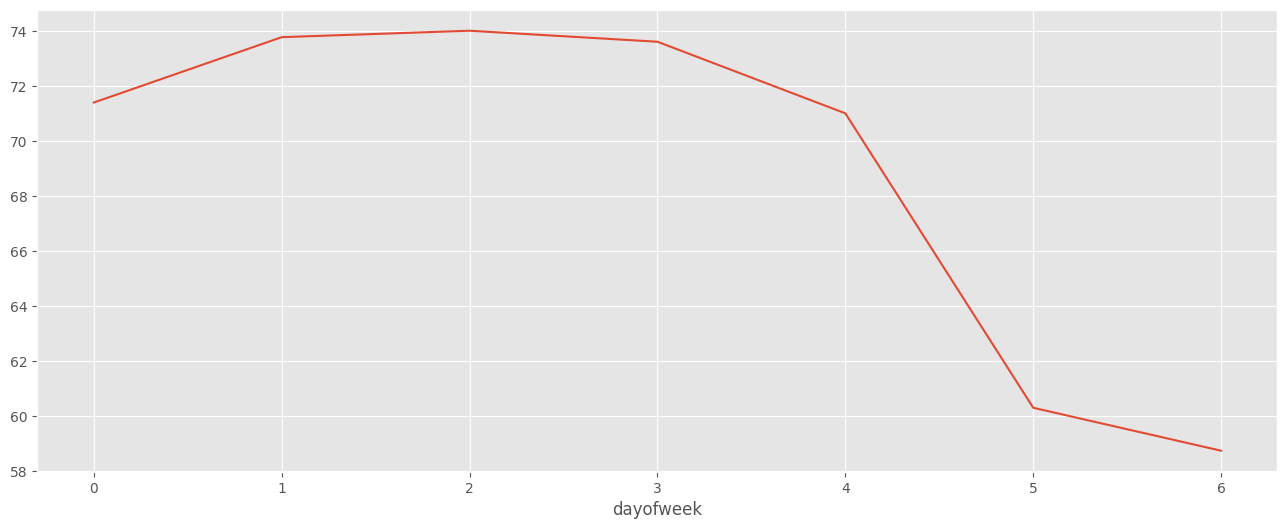

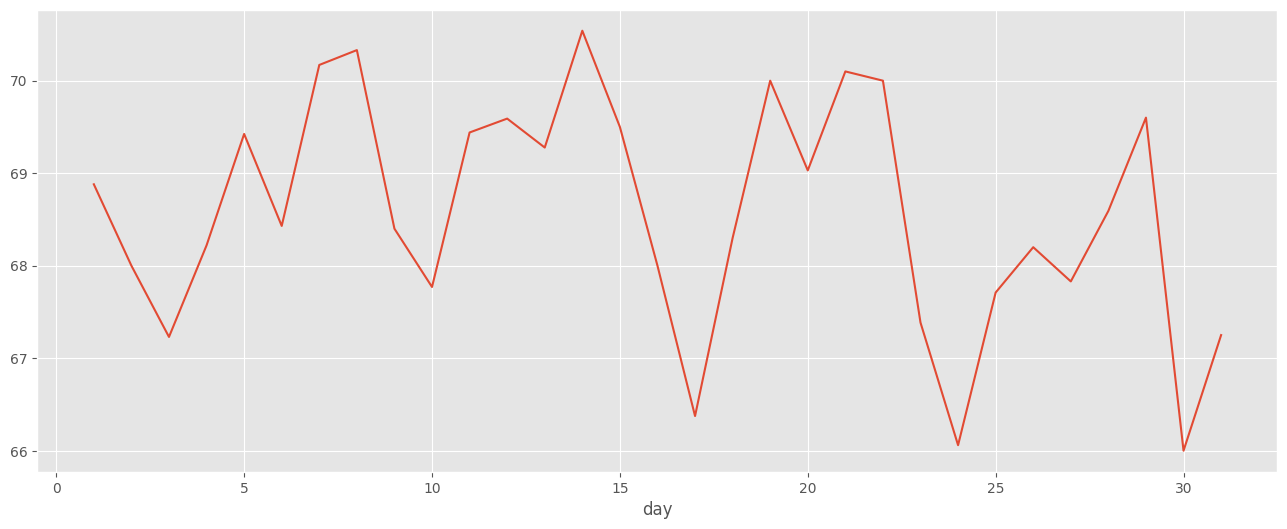

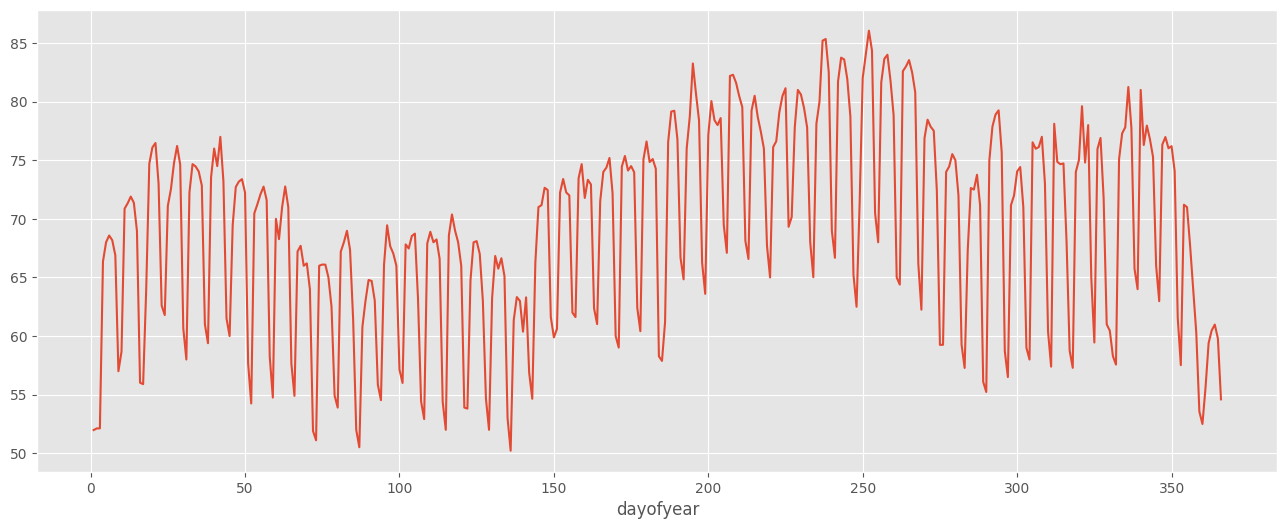

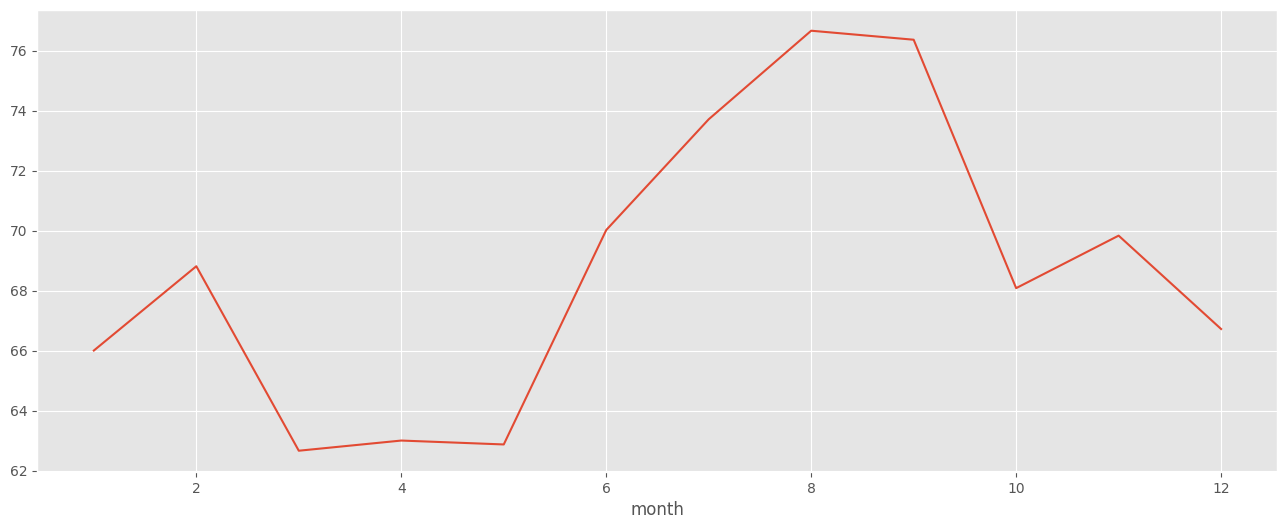

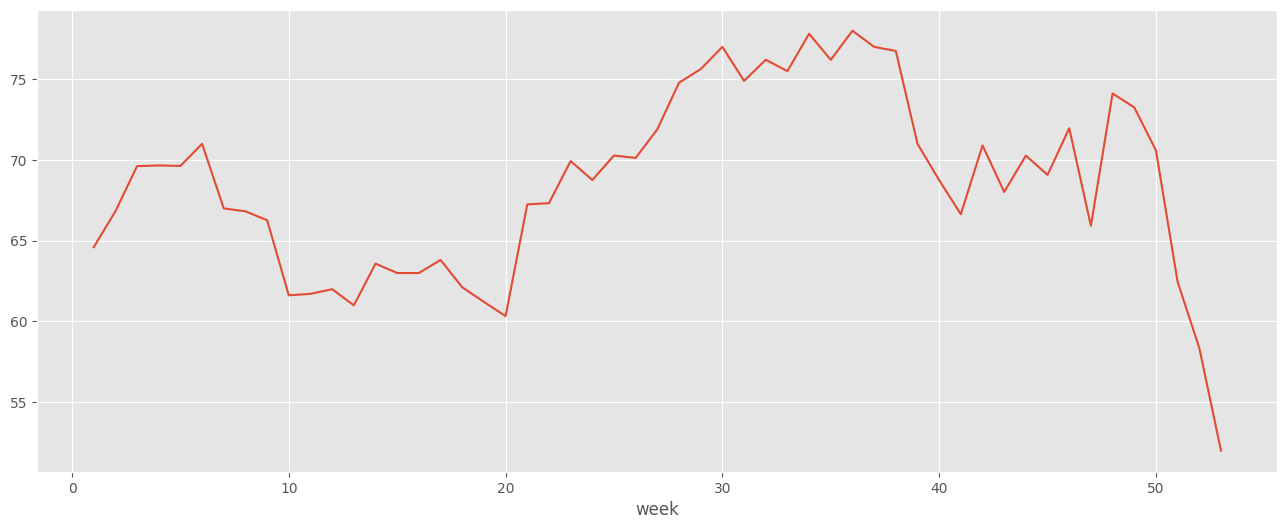

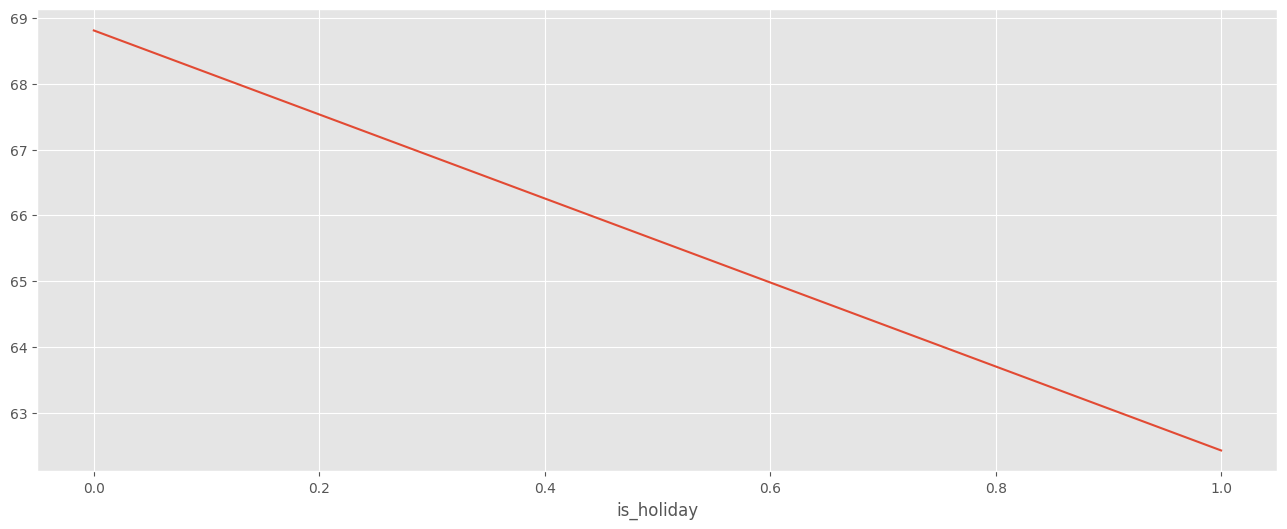

In [67]:
plt.figure(figsize=(16, 6))
energy.groupby("dayofweek")["meter_reading"].median().plot()
plt.show()
plt.figure(figsize=(16, 6))
energy.groupby("day")["meter_reading"].median().plot()
plt.show()
plt.figure(figsize=(16, 6))
energy.groupby("dayofyear")["meter_reading"].median().plot()
plt.show()
plt.figure(figsize=(16, 6))
energy.groupby("month")["meter_reading"].median().plot()
plt.show()
plt.figure(figsize=(16, 6))
energy.groupby("week")["meter_reading"].median().plot()
plt.show()
plt.figure(figsize=(16, 6))
energy.groupby("is_holiday")["meter_reading"].median().plot()
plt.show()